# A. Load and Explore Data

In [15]:
# Install the required packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [16]:
# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [17]:
# Initial exploration
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [19]:
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


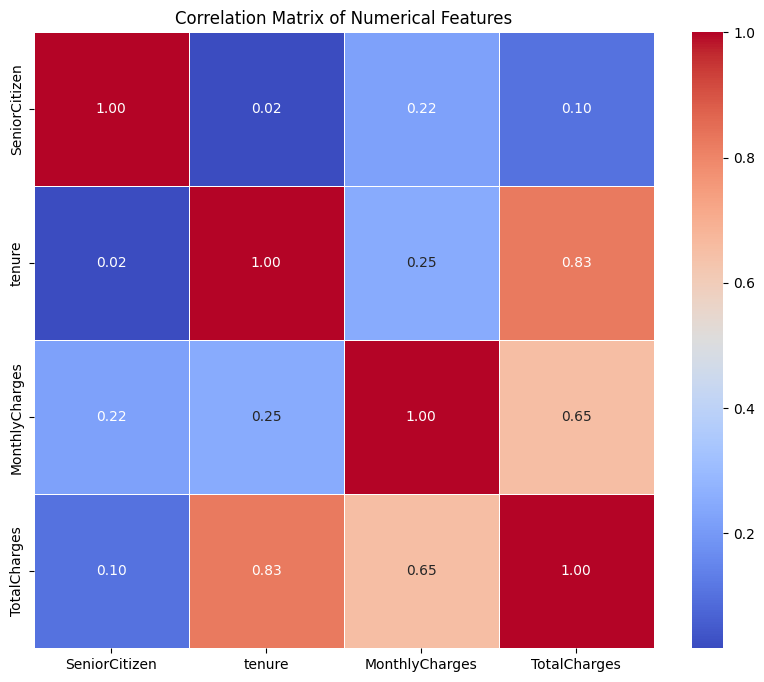

In [28]:
# Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt 

# Select only numerical columns for the correlation matrix
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# B. Data Cleaning and Preprocessing

In [21]:
# The 'TotalCharges' column has missing values and is an object type.
# Convert to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Missing values in 'TotalCharges' appear for customers with 0 tenure.
# We can impute these with 0.
df['TotalCharges'].fillna(0, inplace=True)

# Drop the customerID column as it's not a useful feature
df.drop('customerID', axis=1, inplace=True)

# Separate features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Encode the target variable 'Churn' (Yes/No) to 1/0
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')
Numerical Features: Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


/var/folders/04/m4h1zmms6k1_6vmz7q_8jh_40000gn/T/ipykernel_74560/899953148.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


# C. Build a Preprocessing Pipeline
We use a ColumnTransformer to apply different transformations to different columns.  

This is crucial because we need to save this exact process to use on new data in our web app.

In [23]:
# Create a preprocessor object
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# D. Train the XGBoost Model

In [24]:
# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7729

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.58      0.51      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409



/Users/apple/Desktop/churn_predictor/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:24:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# E. Save the Model and Preprocessor
This is the final and most important step in the notebook. 

We save the trained model pipeline, which includes both the preprocessor and the classifier.

***Note:*** We are saving the entire pipeline, which contains both the preprocessor and the XGBoost classifier. This is simpler and less error-prone than saving them separately.


In [25]:
# Save the entire pipeline to a file
joblib.dump(model, 'model.pkl')

['model.pkl']

# F. Model Evaluation

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7729

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.58      0.51      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409

